In [92]:
import pandas as pd
import numpy as np
import intake

In [93]:
cat = intake.open_catalog('../catalogs/catalog.yml')
measures = cat.measures.read().set_index('cdtfa_id')

In [94]:
# if this file can't be found, run notebook 1 to generate
measures_joined = pd.read_parquet('../data/interim/measures_cdtfa_joined.parquet')

In [95]:
sco_url = 'https://bythenumbers.sco.ca.gov/download/6dj3-r4jw/application%2Fvnd.openxmlformats-officedocument.spreadsheetml.sheet'

In [96]:
sco_entities = pd.read_excel(sco_url, sheet_name='ENTITIES')

In [97]:
sco_rev_exp = pd.read_excel(sco_url, sheet_name='TO_REV_EXP')
sco_rev_exp = sco_rev_exp[sco_rev_exp['Fiscal Year'] == 2019]

In [100]:
lost_transit_funding_2019 = measures_joined[['Calendar Year', 'Quarter', 'Net Amount','county_name', 'county_fips', 'total_pct_transit', 'pct_transit_ops']]

In [101]:
lost_transit_funding_2019['county_name'] = lost_transit_funding_2019['county_name'].replace('Monterey-Salinas Transit District', 'Monterey')

<ipython-input-101-8c5d669f1ea1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost_transit_funding_2019['county_name'] = lost_transit_funding_2019['county_name'].replace('Monterey-Salinas Transit District', 'Monterey')


In [102]:
lost_transit_funding_2019['Net Transit Ops'] = lost_transit_funding_2019['Net Amount'] * lost_transit_funding_2019['pct_transit_ops']
lost_transit_funding_2019['Net Transit All'] = lost_transit_funding_2019['Net Amount'] * lost_transit_funding_2019['total_pct_transit']

<ipython-input-102-6806448d0ebc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost_transit_funding_2019['Net Transit Ops'] = lost_transit_funding_2019['Net Amount'] * lost_transit_funding_2019['pct_transit_ops']
<ipython-input-102-6806448d0ebc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lost_transit_funding_2019['Net Transit All'] = lost_transit_funding_2019['Net Amount'] * lost_transit_funding_2019['total_pct_transit']


In [119]:
sco_rev_exp.columns[sco_rev_exp.columns.str.contains('Fares')]

Index(['Passenger Fares_ Actual_Operating Revenues', 'Passenger Fares_ Budget_Operating Revenues'], dtype='object')

In [120]:
county_lost_funding_19 = lost_transit_funding_2019.groupby('county_name').sum()[['Net Transit Ops', 'Net Transit All']]

In [121]:
agency_sco_total_19 = sco_rev_exp[['Entity ID', 'Entity Name', 'Total Operating Revenues_ Actual_Operating Revenues',
           'Total Operating Expenses_ Actual_Operating Expenses',
            'Total Nonoperating Revenues_ Actual_Nonoperating Revenues',
            'Total Nonoperating Expenses_ Actual_Nonoperating Expenses',
            'Passenger Fares_ Actual_Operating Revenues']]

In [122]:
county_sco_total_19 = (agency_sco_total_19.set_index('Entity ID')
                       .join(sco_entities[['Entity ID', 'County Name']].set_index('Entity ID'))
                      .groupby('County Name').sum())
county_sco_total_19['Total Revenues_Actual'] = (county_sco_total_19['Total Nonoperating Revenues_ Actual_Nonoperating Revenues'] 
                                                + county_sco_total_19['Total Operating Revenues_ Actual_Operating Revenues'])

In [134]:
all_funding_19 = county_lost_funding_19.join(county_sco_total_19)

all_funding_19['Fares ratio of total'] = (
    all_funding_19['Passenger Fares_ Actual_Operating Revenues']
    / all_funding_19['Total Revenues_Actual'])

all_funding_19['LOST ratio of total'] = all_funding_19['Net Transit All'] / all_funding_19['Total Revenues_Actual']
all_funding_19['LOST operations ratio of total'] = all_funding_19['Net Transit Ops'] / all_funding_19['Total Revenues_Actual']

all_funding_19['LOST operations funding ratio of operating expenses'] = (
    all_funding_19['Net Transit Ops'] 
    / all_funding_19['Total Operating Expenses_ Actual_Operating Expenses'] )

all_funding_19 = all_funding_19.rename(columns={'Net Transit Ops': 'LOST Transit Ops', 'Net Transit All': 'LOST Transit All'})

In [135]:
all_funding_19

,LOST Transit Ops,LOST Transit All,Total Operating Revenues_ Actual_Operating Revenues,Total Operating Expenses_ Actual_Operating Expenses,Total Nonoperating Revenues_ Actual_Nonoperating Revenues,Total Nonoperating Expenses_ Actual_Nonoperating Expenses,Passenger Fares_ Actual_Operating Revenues,Total Revenues_Actual,Fares ratio of total,LOST ratio of total,LOST operations ratio of total,LOST operations funding ratio of operating expenses
county_name,,,,,,,,,,,,
Alameda,1.360473e+07,2.742659e+07,666426629.0,1.551864e+09,9.235469e+08,55038921.0,557671334.0,1.589974e+09,0.350743,0.017250,0.008557,0.008767
Contra Costa,5.947064e+06,1.034409e+07,10643535.0,8.655780e+07,6.186824e+07,78037.0,7733673.0,7.251178e+07,0.106654,0.142654,0.082015,0.068706
Fresno,0.000000e+00,8.778743e+06,14228380.0,8.060579e+07,5.271284e+07,72504.0,10483906.0,6.694122e+07,0.156614,0.131141,0.000000,0.000000
Imperial,0.000000e+00,1.044651e+05,2483135.0,9.737597e+06,7.216353e+06,1424572.0,837757.0,9.699488e+06,0.086371,0.010770,0.000000,0.000000
Los Angeles,1.576454e+08,8.672525e+08,686819424.0,3.767198e+09,1.589747e+09,283577741.0,455341357.0,2.276566e+09,0.200012,0.380948,0.069247,0.041847
Madera,0.000000e+00,7.620175e+04,694261.0,2.864945e+06,4.438425e+06,45579.0,162886.0,5.132686e+06,0.031735,0.014846,0.000000,0.000000
Marin,5.003512e+06,5.395944e+06,9137800.0,8.141770e+07,8.122895e+07,6361764.0,7660372.0,9.036675e+07,0.084770,0.059712,0.055369,0.061455
Merced,3.559832e+05,3.559832e+05,1625544.0,1.684783e+07,1.762549e+07,130510.0,1350591.0,1.925103e+07,0.070157,0.018492,0.018492,0.021129
Monterey,3.567664e+06,3.567664e+06,9146630.0,5.622159e+07,4.384214e+07,985757.0,8715328.0,5.298877e+07,0.164475,0.067329,0.067329,0.063457


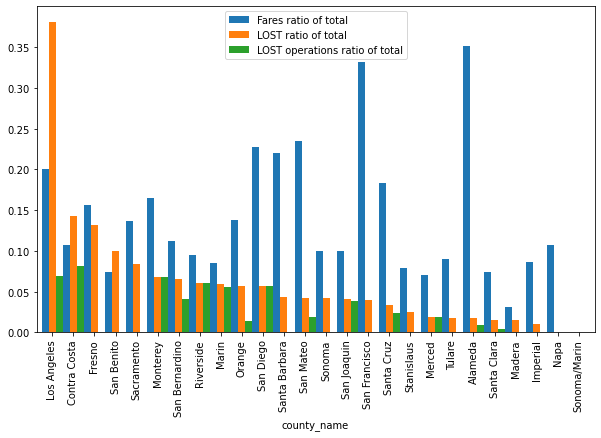

In [146]:
#this info might be better presented as a stacked bar with all funding sources?

(all_funding_19.sort_values('LOST ratio of total', ascending=False)
 [['Fares ratio of total', 'LOST ratio of total', 'LOST operations ratio of total']]
 .plot(kind='bar', width=1, figsize=(10,6)) );

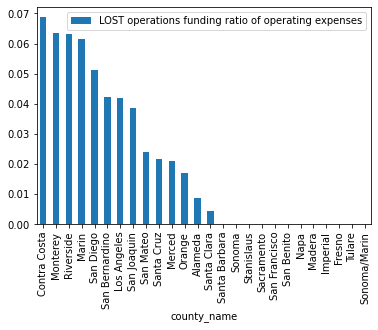

In [133]:
all_funding_19.sort_values('LOST operations funding ratio of operating expenses', ascending=False)[['LOST operations funding ratio of operating expenses']].plot(kind='bar');